In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_9\Project.toml`


In [2]:
using LinearAlgebra
using PyPlot
using SparseArrays
using ForwardDiff
using ControlSystems
using OSQP

In [3]:
#Model parameters
g = 9.81 #m/s^2
m = 1.0 #kg 
ℓ = 0.3 #meters
J = 0.2*m*ℓ*ℓ

#Thrust limits
umin = [0.2*m*g; 0.2*m*g]
umax = [0.6*m*g; 0.6*m*g]

h = 0.05 #time step (20 Hz)

0.05

In [4]:
#Planar Quadrotor Dynamics
function quad_dynamics(x,u)
    θ = x[3]
    
    ẍ = (1/m)*(u[1] + u[2])*sin(θ)
    ÿ = (1/m)*(u[1] + u[2])*cos(θ) - g
    θ̈ = (1/J)*(ℓ/2)*(u[2] - u[1])
    
    return [x[4:6]; ẍ; ÿ; θ̈]
end

quad_dynamics (generic function with 1 method)

In [5]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

quad_dynamics_rk4 (generic function with 1 method)

In [6]:
#Linearized dynamics for hovering
x_hover = zeros(6)
u_hover = [0.5*m*g; 0.5*m*g]
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,u_hover),x_hover);
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x_hover,u),u_hover);
quad_dynamics_rk4(x_hover, u_hover)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [7]:
Nx = 6     # number of state
Nu = 2     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [8]:
# Cost weights
Q = Array(1.0*I(Nx));
R = Array(.01*I(Nu));
Qn = Array(1.0*I(Nx));

In [9]:
#Cost function
function cost(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(size(xhist,2)-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

cost (generic function with 1 method)

In [10]:
#LQR Hover Controller
P = dare(A,B,Q,R)
K = dlqr(A,B,Q,R)

function lqr_controller(t,x,K,xref)
    
    return u_hover - K*(x-xref)
end

lqr_controller (generic function with 1 method)

In [17]:
#Build QP matrices for OSQP
Nh = 20 #one second horizon at 20Hz
Nx = 6
Nu = 2

H = sparse([kron(Diagonal(I,Nh-1),[R zeros(Nu,Nx); zeros(Nx,Nu) Q]) zeros((Nx+Nu)*(Nh-1), Nx+Nu); zeros(Nx+Nu,(Nx+Nu)*(Nh-1)) [R zeros(Nu,Nx); zeros(Nx,Nu) P]])
b = zeros(Nh*(Nx+Nu))

U = kron(Diagonal(I,Nh), [I zeros(Nu,Nx)]) #Matrix that picks out all u
C = sparse([[B -I zeros(Nx,(Nh-1)*(Nu+Nx))]; zeros(Nx*(Nh-1),Nu) [kron(Diagonal(I,Nh-1), [A B]) zeros((Nh-1)*Nx,Nx)] + [zeros((Nh-1)*Nx,Nx) kron(Diagonal(I,Nh-1),[zeros(Nx,Nu) Diagonal(-I,Nx)])]])

Θ = kron(Diagonal(I,Nh), [0 0 0 0 1 0 0 0]) #Matrix that picks out all x3 (θ)

#Dynamics + Thrust limit constraints
#D = [C; U]
#lb = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover)]
#ub = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover)]

#Dynamics + thrust limit + bound constraint on θ to keep the system within small-angle approximation
# D = [C; U; Θ]
# lb = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover); -0.2*ones(Nh)]
# ub = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover); 0.2*ones(Nh)]

prob = OSQP.Model()
OSQP.setup!(prob; P=H, q=b, A=D, l=lb, u=ub, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);

In [18]:
#MPC Controller
function mpc_controller(t,x,xref)
    
    #Update QP problem
    lb[1:6] .= -A*x
    ub[1:6] .= -A*x
    
    for j = 1:(Nh-1)
        b[(Nu+(j-1)*(Nx+Nu)).+(1:Nx)] .= -Q*xref
    end
    b[(Nu+(Nh-1)*(Nx+Nu)).+(1:Nx)] .= -P*xref
    
    OSQP.update!(prob, q=b, l=lb, u=ub)

    #Solve QP
    results = OSQP.solve!(prob)
    Δu = results.x[1:Nu]

    return u_hover + Δu
end

mpc_controller (generic function with 1 method)

In [19]:
function closed_loop(x0,controller,N)
    xhist = zeros(length(x0),N)
    u0 = controller(1,x0)
    uhist = zeros(length(u0),N-1)
    uhist[:,1] .= u0
    xhist[:,1] .= x0
    for k = 1:(N-1)
        uk = controller(k,xhist[:,k])
        uhist[:,k] = max.(min.(umax, uk), umin) #enforce control limits
        xhist[:,k+1] .= quad_dynamics_rk4(xhist[:,k],uhist[:,k])
    end
    return xhist, uhist
end

closed_loop (generic function with 1 method)

In [20]:
x_ref = [0.0; 1.0; 0; 0; 0; 0]
x0 = [10.0; 2.0; 0.0; 0; 0; 0]
xhist1, uhist1 = closed_loop(x0, (t,x)->lqr_controller(t,x,K,x_ref), Nt);
xhist2, uhist2 = closed_loop(x0, (t,x)->mpc_controller(t,x,x_ref), Nt);
xhist2

6×201 Matrix{Float64}:
 10.0   9.99993      9.99922     9.99628    …   0.00235436    0.00223953
  2.0   1.99755      1.98669     1.96729        0.999994      0.999995
  0.0  -0.040875    -0.134531   -0.199219       0.00024006    0.000228343
  0.0  -0.00534552  -0.0270276  -0.0948258     -0.00235443   -0.00223957
  0.0  -0.0981819   -0.336355   -0.440445       5.74787e-6    5.46997e-6
  0.0  -1.635       -2.11125    -0.47625    …  -0.000240199  -0.00022847

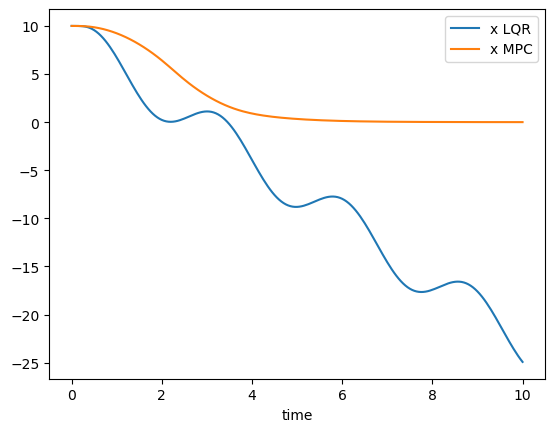

PyObject <matplotlib.legend.Legend object at 0x000000007E926560>

In [21]:
plot(thist,xhist1[1,:], label="x LQR")
plot(thist,xhist2[1,:], label="x MPC")
xlabel("time")
legend()

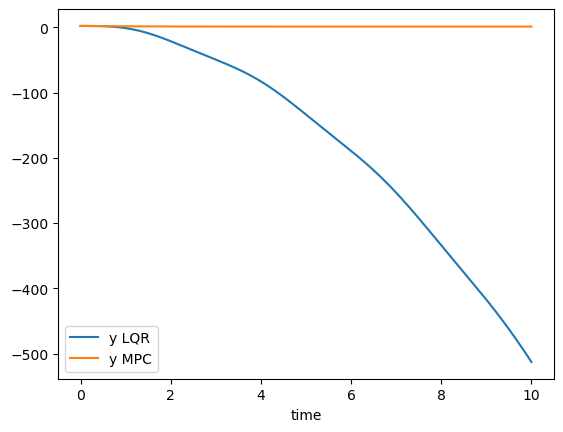

PyObject <matplotlib.legend.Legend object at 0x00000000639D32E0>

In [22]:
plot(thist,xhist1[2,:], label="y LQR")
plot(thist,xhist2[2,:], label="y MPC")
xlabel("time")
legend()

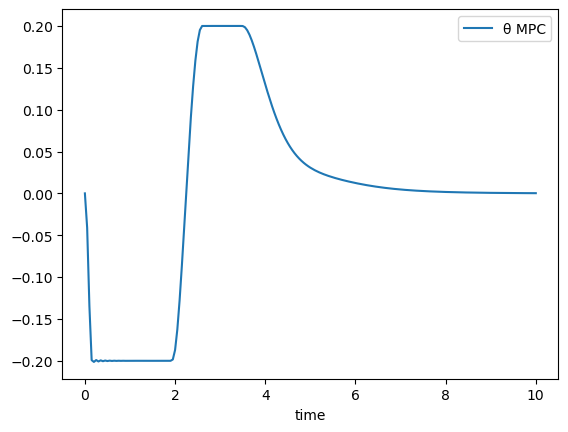

PyObject <matplotlib.legend.Legend object at 0x0000000063A5E470>

In [23]:
#plot(thist,xhist1[3,:], label="θ LQR")
plot(thist,xhist2[3,:], label="θ MPC")
xlabel("time")
legend()

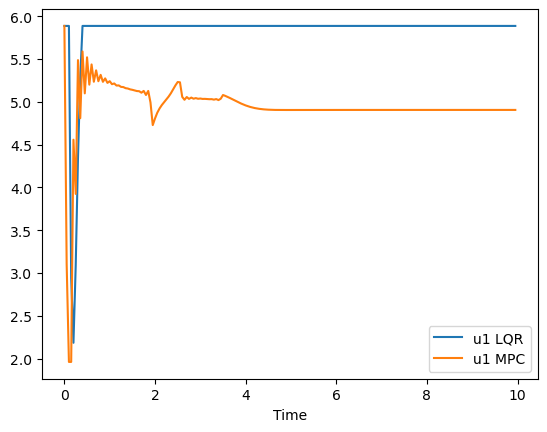

PyObject <matplotlib.legend.Legend object at 0x0000000063AE6920>

In [24]:
plot(thist[1:end-1], uhist1[1,:], label="u1 LQR")
plot(thist[1:end-1], uhist2[1,:], label="u1 MPC")
xlabel("Time")
legend()

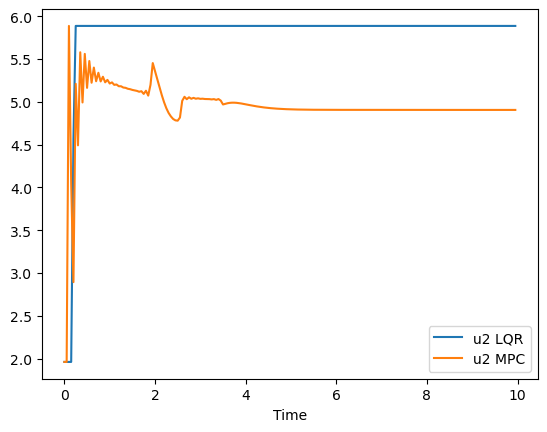

PyObject <matplotlib.legend.Legend object at 0x0000000063B6FF10>

In [25]:
plot(thist[1:end-1], uhist1[2,:], label="u2 LQR")
plot(thist[1:end-1], uhist2[2,:], label="u2 MPC")
xlabel("Time")
legend()

In [26]:
#Set up visualization
using MeshCat
using RobotZoo: Quadrotor, PlanarQuadrotor
using CoordinateTransformations, Rotations, Colors, StaticArrays, RobotDynamics

function set_mesh!(vis, model::L;
        scaling=1.0, color=colorant"black"
    ) where {L <: Union{Quadrotor, PlanarQuadrotor}} 
    # urdf_folder = joinpath(@__DIR__, "..", "data", "meshes")
    urdf_folder = @__DIR__
    # if scaling != 1.0
    #     quad_scaling = 0.085 * scaling
    obj = joinpath(urdf_folder, "quadrotor_scaled.obj")
    if scaling != 1.0
        error("Scaling not implemented after switching to MeshCat 0.12")
    end
    robot_obj = MeshFileGeometry(obj)
    mat = MeshPhongMaterial(color=color)
    setobject!(vis["robot"]["geom"], robot_obj, mat)
    if hasfield(L, :ned)
        model.ned && settransform!(vis["robot"]["geom"], LinearMap(RotX(pi)))
    end
end

function visualize!(vis, model::PlanarQuadrotor, x::StaticVector)
    py,pz = x[1], x[2]
    θ = x[3]
    settransform!(vis["robot"], compose(Translation(0,py,pz), LinearMap(RotX(-θ))))
end

function visualize!(vis, model, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = MeshCat.Animation(fps)
    for (k,x) in enumerate(X)
        atframe(anim, k) do
            x = X[k]
            visualize!(vis, model, SVector{6}(x)) 
        end
    end
    setanimation!(vis, anim)
end

visualize! (generic function with 2 methods)

In [27]:
vis = Visualizer()
model = PlanarQuadrotor()
set_mesh!(vis, model)
render(vis)

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8700), "127.0.0.1", "8700", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x00000000000019b4) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x0000000079277530)))

In [28]:
X1 = [SVector{6}(x) for x in eachcol(xhist1)];
X2 = [SVector{6}(x) for x in eachcol(xhist2)];

In [29]:
visualize!(vis, model, thist[end], X1)

In [30]:
visualize!(vis, model, thist[end], X2)